# Project pRF analysis results to pycortex surfaces
Make sure you have created the pycortex entries for these individuals (https://github.com/VisionandCognition/NHP-pycortex)     
Strategy:    
- Load all (unthresholded) results into sorted numpy arrays with nibabel
- Also create pycortex volume objects
- Save them in an ordered dictionary
- Define some functions for masking
- Perform any additional post-processing

### Import the required modules

In [1]:
import cortex
import nibabel as nib 
import numpy as np
import pandas as pd
import os, shutil, copy

from matplotlib import pyplot as plt

### Set subject name and path to FitResults

In [2]:
subj = 'Danny' # 'Danny'/'Eddy'
FitResPath = os.path.join('/Users','chris','Documents','MRI_ANALYSIS','NHP-PRF','FitResults')
ManualMaskPath = os.path.join('/Users','chris','Dropbox','GIT_Support','NHP-BIDS','manual-masks')

### Specify which models and results to include
Making changes here may or may not break subsequent as it relies on some of these things being present (e.g., R2, R2_1, and R2_2)

In [3]:
Models = {
    'dhrf' : ['linhrf_cv1_dhrf','linhrf_cv1_dhrf_neggain','csshrf_cv1_dhrf','doghrf_cv1_dhrf'],
    'mhrf' : ['linhrf_cv1_mhrf','linhrf_cv1_mhrf_neggain','csshrf_cv1_mhrf','doghrf_cv1_mhrf'],
    'names' : ['lin','lin_ng','css','dog'],
}
Res_type = ['ANG', 'ECC', 'EXPT', 'FWHM', 'GAIN', 'IMAG', 'REAL', 'RFS', 'X', 'Y', 'NAMP', 'SDRATIO']
xfm = 'epi2surf'

### Create a volume to vertex mapper for this subject

In [4]:
Vol2Vertex_mapper = cortex.get_mapper(subj, xfm, 'line_nearest', recache=True)

### Create a dictionary to collect all FitResults in

In [5]:
# this will be the structure of data collection
FR = {
    'subject' : subj,
    'xfm' : xfm,
    'mHRF' : {
        'arr' : {},
        'vol' : {},
    },
    'dHRF' : {
        'arr' : {},
        'vol' : {},
    },
}

### Populate the dictionary with the data

In [6]:
# Get the data
for h in ['m','d']:
    print('Processing ' + h + 'HRF:', end='')
    for M in Models[h + 'hrf']:
        # get model idx so we create a shorter variable name
        midx = Models[h + 'hrf'].index(M)
        print(' ' + Models['names'][midx], end='')
        
        # get the mean R2 map
        volpath = os.path.join(FitResPath,'MRI',subj.lower(),M,'Sess-' + M + '_meanR2.nii.gz')
        volpath1 = os.path.join(FitResPath,'MRI',subj.lower(),M,'Sess-' + M + '_R2_1.nii.gz')
        volpath2 = os.path.join(FitResPath,'MRI',subj.lower(),M,'Sess-' + M + '_R2_2.nii.gz')

        # load the results into numpy arrays with nibabel
        R2 = np.array(nib.load(volpath).dataobj)
        R2_1 = np.array(nib.load(volpath1).dataobj)
        R2_2 = np.array(nib.load(volpath2).dataobj)

        # convert to pycortex volumes
        R2v = cortex.Volume(R2.transpose(2,1,0), subj, xfm)
        R2_1v = cortex.Volume(R2_1.transpose(2,1,0), subj, xfm)
        R2_2v = cortex.Volume(R2_2.transpose(2,1,0), subj, xfm)

        # add info to dictionaries
        # numpy arrays
        FitRes = {
            'R2' : R2,
            'R2_1' : R2_1,
            'R2_2' : R2_2
            }
        # pycortex volumes
        FitRes_vol = {
            'R2' : R2v,
            'R2_1' : R2_1v,
            'R2_2' : R2_2v
            }

        # also get othere results
        for R in Res_type:
            volpath = os.path.join(FitResPath,'MRI',subj.lower(),M,'TH_0', R + '_th0.nii.gz')
            if os.path.exists(volpath):
                FitRes[R] = np.array(nib.load(volpath).dataobj)
                FitRes_vol[R] = cortex.Volume(FitRes[R].transpose(2,1,0), subj, xfm)

        # bring it all together
        FR[h + 'HRF']['arr'][Models['names'][midx]] = FitRes
        FR[h + 'HRF']['vol'][Models['names'][midx]] = FitRes_vol
    print('')

Processing mHRF: lin lin_ng css dog
Processing dHRF: lin lin_ng css dog


In [11]:
if True:
    # Check in webviewer 
    cortex.webgl.show(data=FR['mHRF']['vol']['lin'])
    cortex.webgl.show(data=FR['mHRF']['vol']['lin_ng'])

Started server on port 61427
Started server on port 51831
Stopping server
Stopping server
Stopping server


In [10]:
R2_diffarray = FR['mHRF']['arr']['lin']['R2'] - FR['mHRF']['arr']['lin_ng']['R2']
FR['mHRF']['vol']['lin_ng']['R2_DIFF'] = cortex.Volume(R2_diffarray.transpose(2,1,0), subj, xfm)
cortex.webgl.show(data=FR['mHRF']['vol']['lin_ng'])

Started server on port 39003


<JS: window.viewer>

### Do some checks to see if this worked as expected
Once we know it worked we can switch this off again

In [8]:
if False:
    # Inspect the result volumes (should be numpy arrays)
    RR = copy.copy(FR['mHRF']['arr']['lin']['R2']) # copy the R2 values for some model
    RR[RR < 5] ='nan' # threshold it to some level
    
    cortex.webgl.show(data=cortex.Volume(RR.transpose(2,1,0), subj, xfm)) # check to seeit worked

### Define a function to mask the results based on R2 values
This function makes a deepcopy of the input dictionary to prevend overwriting it with masked data. Than masks it with the provided R2-threshold

In [19]:
def r2mask(DataDict,RTH):
    DD = copy.deepcopy(DataDict) # copy the original data so it won't get overwritten
    # mask the numpy arrays by inserting nan's
    for hrf in ['mHRF','dHRF']:
        for m in DD[hrf]['arr']:
            # mask all available outputs except for R2
            for res in DD[hrf]['arr'][m]:
                if res is not 'R2':
                    with np.errstate(invalid='ignore'):
                        DD[hrf]['arr'][m][res][ DD[hrf]['arr'][m]['R2'] < RTH ] = 'nan'
                    # also convert to the pycortex volume
                    DD[hrf]['vol'][m][res] = cortex.Volume(DD[hrf]['arr'][m][res].transpose(2,1,0), DD['subject'], DD['xfm'])
            # mask R2            
            with np.errstate(invalid='ignore'):
                DD[hrf]['arr'][m]['R2'][ DD[hrf]['arr'][m]['R2'] < RTH ] = 'nan' 
            DD[hrf]['vol'][m]['R2'] = cortex.Volume(DD[hrf]['arr'][m]['R2'].transpose(2,1,0), DD['subject'], DD['xfm'])

    return DD

Check whether the masking function works

In [10]:
if False:
    mFR = r2mask(FR,2)
    cortex.webgl.show(data=mFR['mHRF']['vol']['lin'])

### Get D99 atlas information 

In [11]:
# read atlas labels
D99_inFunc = {}
D99_inFunc['path'] = os.path.join(ManualMaskPath,'sub-' + subj.lower(),'atlas','D99_in_' + subj + '_adj_inFunc.nii')
D99_inFunc['arr'] = np.array(nib.load(D99_inFunc['path']).dataobj)
D99_inFunc['vol'] = cortex.Volume(D99_inFunc['arr'].transpose(2,1,0), subj, xfm)
D99_inFunc['labelpath'] = os.path.join(ManualMaskPath,'sub-' + subj.lower(),'atlas','D99_labeltable_reformat.txt')

D99_inFunc['labels'] = {}
with open(D99_inFunc['labelpath']) as f:
    for line in f:
        labelnum, label = line.strip().split(' ',1)
        D99_inFunc['labels'][label.strip()] = int(labelnum)
#print(D99_inFunc['labels'])

In [13]:
if False:
    cortex.webgl.show(data=D99_inFunc['vol'])

### Define a function that returns ROI names from voxel label number

In [14]:
def get_roiname(LabelDict,LabelNum):
    for name, number in LabelDict.items():
        if number == LabelNum:
            return name

In [15]:
# test if the get_roiname function works
if False:
    roi = get_roiname(D99_inFunc['labels'],34)
    print(roi)

### Define a function that returns data masked by ROI

In [18]:
def roimask(DataDict,AtlasDict,rois):
    # DataDict is the dictionary of results
    # AtlasDict is a dictionary of D99 atlas info
    # rois is a list of rois to include
    
    DD = copy.deepcopy(DataDict) # copy the original data so it won't get overwritten
    AA = copy.deepcopy(AtlasDict) # copy the original data so it won't get overwritten
    
    # Create a mask that includes all rois in the list
    mask = np.zeros(AA['arr'].shape)
    for r in rois:
        tmask = AA['arr']==AA['labels'][r]
        mask = mask + tmask
    mask[mask > 0]
    
    # mask the numpy arrays by inserting nan's
    for hrf in ['mHRF','dHRF']:
        for m in DD[hrf]['arr']:
            # mask all available outputs except for R2
            for res in DD[hrf]['arr'][m]:
                with np.errstate(invalid='ignore'):
                    DD[hrf]['arr'][m][res][ mask < 1 ] = 'nan'
                # also convert to the pycortex volume
                DD[hrf]['vol'][m][res] = cortex.Volume(DD[hrf]['arr'][m][res].transpose(2,1,0), DD['subject'], DD['xfm'])
    return DD

In [17]:
# test this function
if False:
    V1Res = roimask(FR,D99_inFunc,['V1'])
    cortex.webgl.show(data=V1Res['mHRF']['vol']['lin'])

In [21]:
# test masking by ROI and R2
if True:
    V1Res = roimask(FR,D99_inFunc,['V1'])
    mV1Res = r2mask(V1Res,4)
    cortex.webgl.show(data=mV1Res['mHRF']['vol']['lin'])

Started server on port 47986


### Define a function to interpolate (masked) surface results

In [24]:
# First just script it, we can create a function later

# Get the volume you want to work with
StartVol = mV1Res['mHRF']['vol']['lin']['R2']
np.shape(StartVol)

(56, 90, 90)

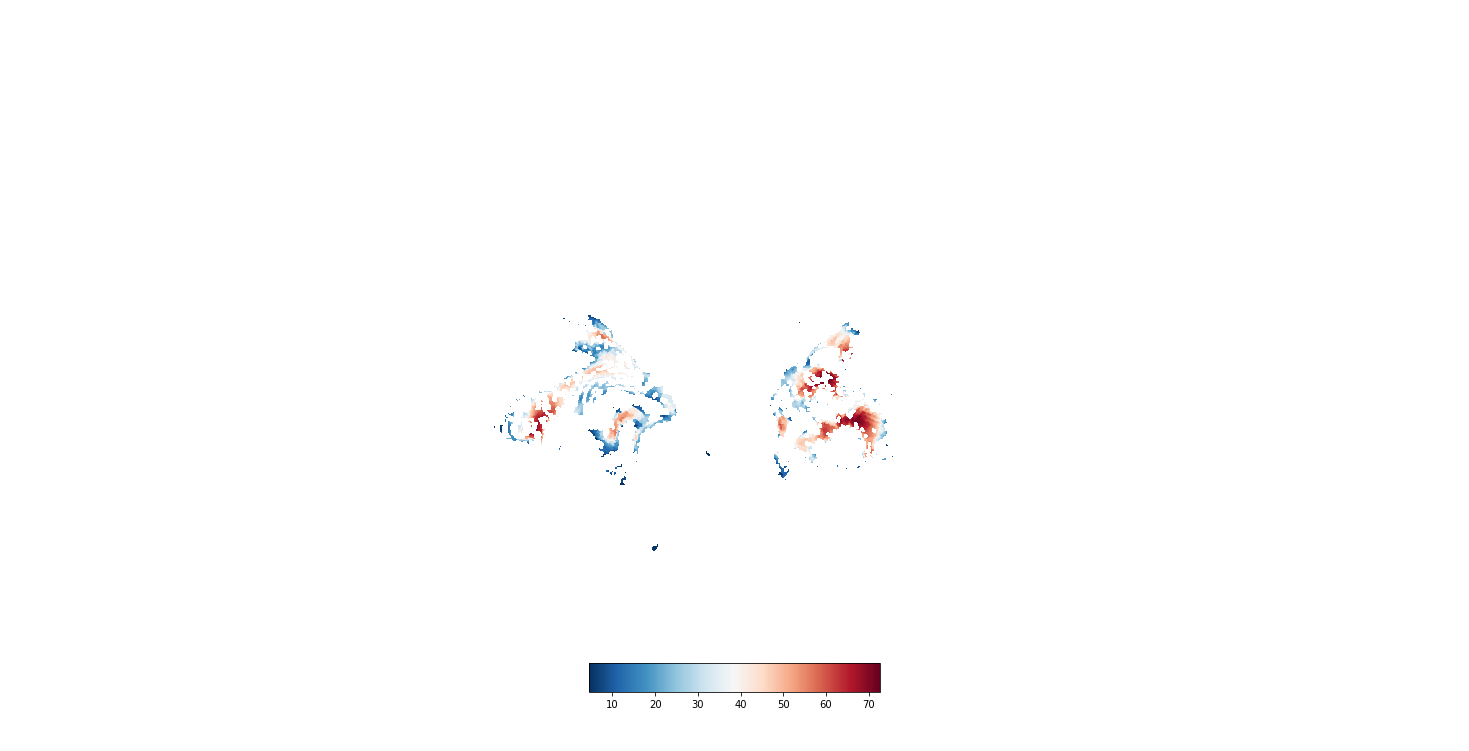

In [30]:
# map volume results to vertex
DataVertex = Vol2Vertex_mapper(StartVol)

# let's see if this worked
#cortex.quickshow(DataVertex,with_rois=0)
#plt.show()

# get vertex coordinates with data
DataVertex

In [27]:
cortex.quickshow?

Signature:
cortex.quickshow(
    braindata,
    recache=False,
    pixelwise=True,
    thick=32,
    sampler='nearest',
    height=1024,
    dpi=100,
    depth=0.5,
    with_rois=True,
    with_sulci=False,
    with_labels=True,
    with_colorbar=True,
    with_borders=False,
    with_dropout=False,
    with_curvature=False,
    extra_disp=None,
    with_connected_vertices=False,
    overlay_file=None,
    linewidth=None,
    linecolor=None,
    roifill=None,
    shadow=None,
    labelsize=None,
    labelcolor=None,
    cutout=None,
    curvature_brightness=None,
    curvature_contrast=None,
    curvature_threshold=None,
    fig=None,
    extra_hatch=None,
    colorbar_ticks=None,
    colorbar_location=(0.4, 0.07, 0.2, 0.04),
    roi_list=None,
    nanmean=False,
    **kwargs,
)
Docstring:
Show a Volume or Vertex on a flatmap with matplotlib.

Note that **kwargs are ONLY present now for backward compatibility / warnings. No kwargs
should be used.

Parameters
----------
braindata : Data

In [ ]:
DataVertex.

In [ ]:
def interpsurf(xxx,subject)
    # import the pycortex surface tools
    from cortex.polyutils import Surface as surf
    
    
    
    np.random.seed(1234) 
    subject = "S1"

# First we need to import the surfaces for this subject
lsurf, rsurf = [Surface(*d) for d in cortex.db.get_surf(subject, "fiducial")]

# Let's choose a few points and generate data for them
selected_pts = np.arange(len(lsurf.pts), step=5000)
num_selected_pts = len(selected_pts)
sparse_data = np.random.randn(num_selected_pts)

# Then interpolate
interp_data = lsurf.interp(selected_pts, sparse_data)

# Plot the result
# interp_data is only for the left hemisphere, but the Vertex constructor
# infers that and fills the right hemisphere with zeros
interp_vertex = cortex.Vertex(interp_data[:,0], subject, 
                              vmin=-2, vmax=2, cmap='RdBu_r')
cortex.quickshow(interp_vertex, with_labels=False, with_rois=False)


# plot the locations of the points we selected originally

# nudge=True puts both left and right hemispheres in the same space, moving them
# so that they don't overlap. These are the coordinates used in quickflat
(lflatpts, lpolys), (rflatpts, rpolys) = cortex.db.get_surf(subject, "flat", 
                                                            nudge=True)

ax = plt.gca()
# zorder is set to 10 to make sure points go on top of other quickflat layers
ax.scatter(lflatpts[selected_pts,0], lflatpts[selected_pts,1], s=50, 
           c=sparse_data, vmin=-2, vmax=2, cmap=plt.cm.RdBu_r, zorder=10)


# the interpolate function can also handle multiple dimensions at the same time
# (this takes a while to run for no plotting, and thus is commented out)
#sparse_data_2d = np.random.randn(10, num_selected_pts)
#interp_data_2d = lsurf.interp(selected_pts, sparse_data_2d)

# > interp_data_2d.shape
# (152893, 10)
plt.show()



